The goal of this exercise is to predict if the Titanic passengers in the test set survived. I have used Stacking to train my model. Stacking is an ensemble technique where predictions from multiple models are used to generate a second level model called meta-model. This second-layer algorithm is trained to optimally combine the model predictions to form a new set of predictions. There are many good resources online that explain this concept in detail.

In this kernel, I have tried multiple classification algorithms and used cross validation score to pick the 5 best models. These 5 models are called base models. The predictions from these base models serve as the input to the second-level model called the meta-model. I used Random Forest for fitting my meta-model. To predict the results, I used the base models to generate first-level predictions on test set. These first level predictions from the base models were used as the input to the meta model. 

This kernel is a combination of multiple approaches that I have learned through various online courses and books.  

First, we will import the libraries: 

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

In [282]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [283]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [284]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [285]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [286]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [287]:
len(train)

891

In [288]:
len(test)

418

### Missing Values

In [289]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [290]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


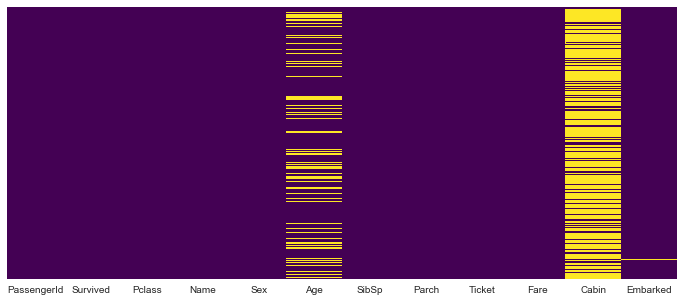

In [291]:
plt.figure(figsize=(12,5))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

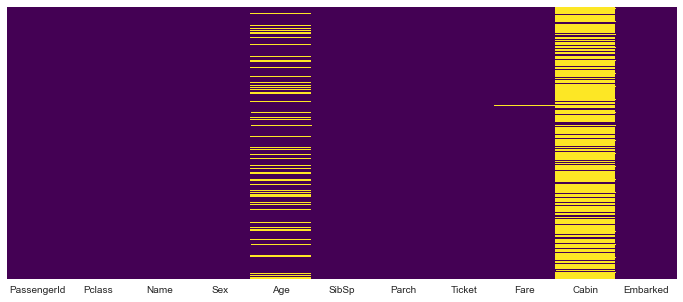

In [292]:
plt.figure(figsize=(12,5))
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Impute Missing Values

Age and Cabin columns contain many missing values. 77% of the observations for Cabin do not contain a value. ML algorithms will not be able to handle such a large number of missing values. We will drop the Cabin column.

In [293]:
train.drop(['Cabin'], axis =1, inplace=True)
test.drop(['Cabin'], axis = 1, inplace=True)

In [294]:
combined = pd.concat([train,test])

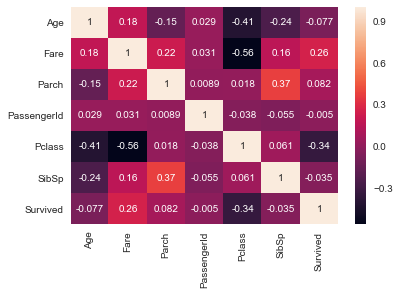

In [295]:
sns.heatmap(combined.corr(),annot=True)

There is a good correlation between Age and PClass. I will use PClass value to impute Age, where it is misisng.

In [296]:
combined.groupby('Pclass').mean()['Age']

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [297]:
def setAge(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return 39
        elif pclass == 2:
            return 30
        else:
            return 25
    else:
        return age

In [298]:
train['Age'] = train[['Age','Pclass']].apply(setAge,axis=1)
test['Age'] = test[['Age','Pclass']].apply(setAge,axis=1)

combined['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

As Southampton is the most common value for port emabrked, I will replace the misisng values with 'S'

In [299]:
train['Embarked'] = train['Embarked'].replace(np.NaN, 'S') 
test['Embarked'] = test['Embarked'].replace(np.NaN, 'S') 
    

There is one observation in the Train data set that is misisng Fare information. I will set the value based on the mean  of 3rd class fare.

In [300]:
combined.groupby('Pclass').mean()['Fare']

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [301]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [302]:
test["Fare"].fillna(13.30, inplace=True)
print(train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [303]:
print(test.isnull().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


The above steps resolve all the missing values. We no longer have any missing values.

## EDA & Feature Engineering

This is my favorite phase of any data science project. I feel it is important to analyze all variables in the data set. Most of my analysis is limited to the target variable 'Survived' but I have included some analysis on relationsips between other columns. 

### Sex

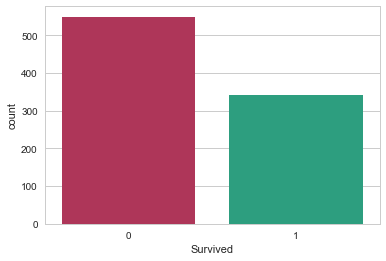

In [304]:
sns.countplot(train['Survived'],palette= {1: "#1ab188", 0: "#c22250"})

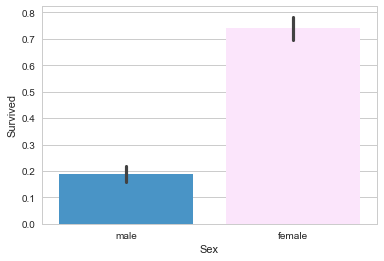

In [305]:
sns.barplot(data=train,x='Sex',y='Survived',palette= {'male': "#3498db", 'female': "#ffe1ff"})

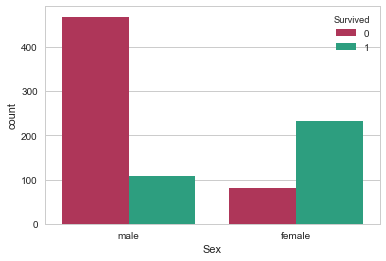

In [306]:
#Sex
sns.countplot(data=train,x='Sex',hue='Survived',palette= {1: "#1ab188", 0: "#c22250"})

### Parch, SibSp and Family Size

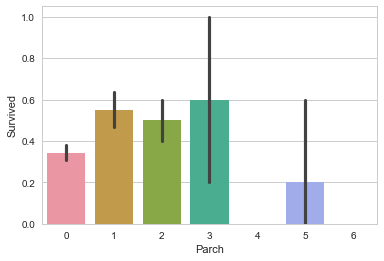

In [307]:
sns.barplot(data=train,x='Parch',y='Survived')

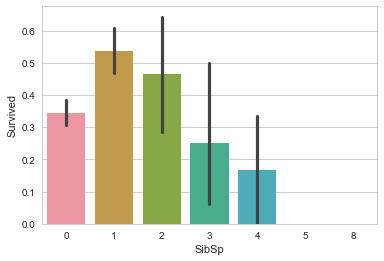

In [308]:
sns.barplot(data=train,x='SibSp',y='Survived')

As the SibSp and Parch columns are not very different, I will combine them into a single column called Family Size

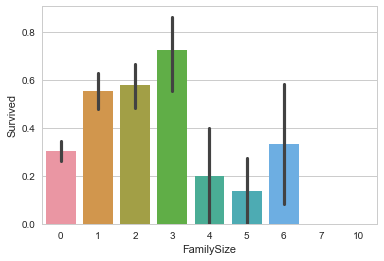

In [309]:
train['FamilySize'] = train['SibSp'] + train ['Parch']
test['FamilySize'] = test['SibSp'] + test ['Parch']

sns.barplot(data=train,x='FamilySize',y='Survived')

Survival probability is low for single travelers. So I will create a column to identify the solo travellers.

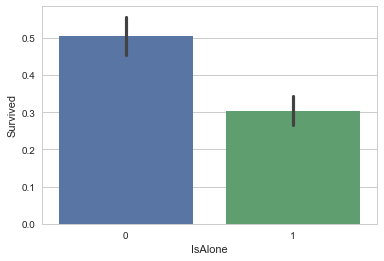

In [310]:
def isAlone(cols):
    if (cols[0]==0) & (cols[1]==0):
        return 1
    else:
        return 0
train['IsAlone'] = train[['SibSp','Parch']].apply(isAlone,axis=1)
test['IsAlone'] = test[['SibSp','Parch']].apply(isAlone,axis=1)

sns.barplot(data=train,x='IsAlone',y='Survived')

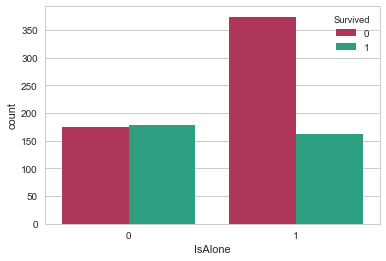

In [311]:
sns.countplot(data=train,x='IsAlone',hue='Survived',palette= {1: "#1ab188", 0: "#c22250"})

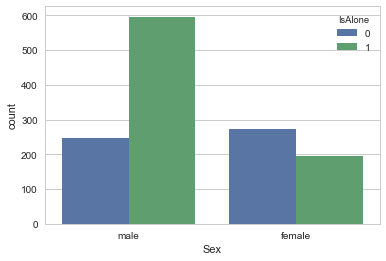

In [312]:
#sns.countplot(data=train,x='Sex',hue='IsAlone')
combined = pd.concat([train,test])
sns.countplot(data=combined,x='Sex',hue='IsAlone')

### Age

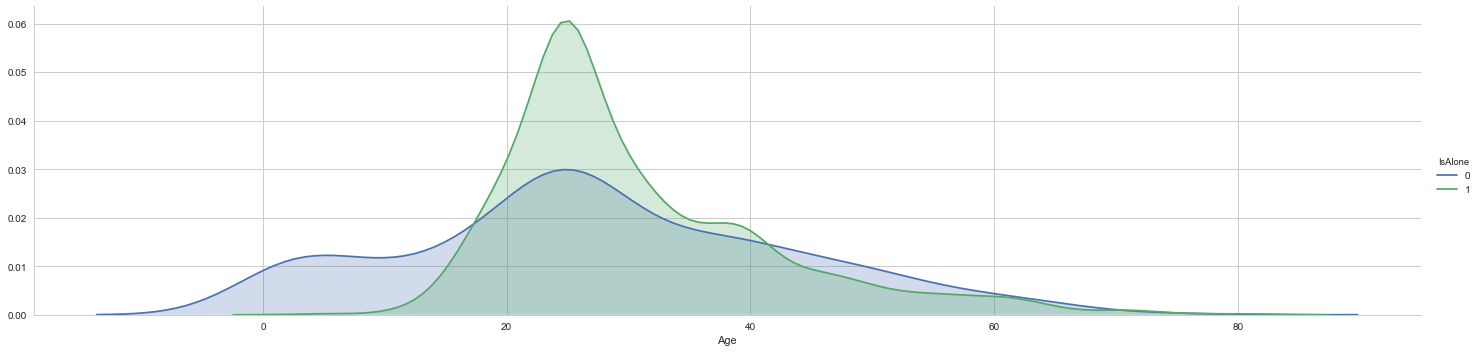

In [313]:
f = sns.FacetGrid(combined,hue='IsAlone',size=5,aspect=4)
f.map(sns.kdeplot,'Age',shade= True)
f.add_legend()

In [314]:
combined[(combined['IsAlone'] == True)].sort_values(['Age']).head()

,Age,Embarked,FamilySize,Fare,IsAlone,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
777,5.0,S,0,12.4750,1,"Emanuel, Miss. Virginia Ethel",0,778,3,female,0,1.0,364516
731,11.0,C,0,18.7875,1,"Hassan, Mr. Houssein G N",0,732,3,male,0,0.0,2699
120,12.0,S,0,15.7500,1,"Watt, Miss. Bertha J",0,1012,2,female,0,NaN,C.A. 33595
780,13.0,C,0,7.2292,1,"Ayoub, Miss. Banoura",0,781,3,female,0,1.0,2687
14,14.0,S,0,7.8542,1,"Vestrom, Miss. Hulda Amanda Adolfina",0,15,3,female,0,0.0,350406


The 2 plots above may not be of much significance to this challenge but I find them interesting. We observe that most female travelers had a family member travelling with them. Most of the travelers sailing alone were in the age group of 17-40. The youngest solo traveler was just 5 years and she survived. This piqued my curiosity and I found that she was travelling with a nursemaid. More information about Virginia Ethel: https://www.encyclopedia-titanica.org/titanic-survivor/virginia-ethel-emanuel.html. 
The second youngest solo traveler was not that fortunate. He was travelling with a relative. That's it for now, lets continue with the challenge.

In [315]:
#train['AgeBand'] = (train['Age']/5).astype(int)
#test['AgeBand'] = (test['Age']/5).astype(int)

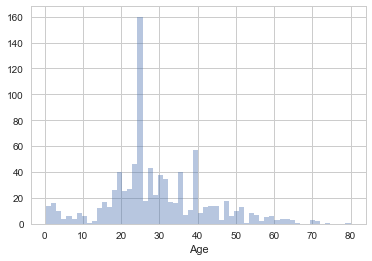

In [316]:
sns.distplot(train['Age'].dropna(),kde=False,bins=60)

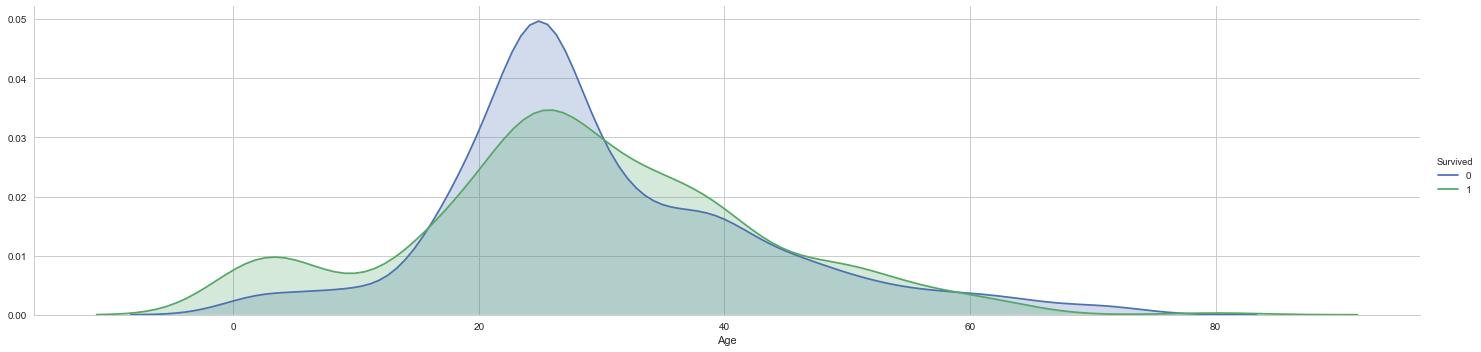

In [317]:
f = sns.FacetGrid(train,hue='Survived',size=5,aspect=4)
f.map(sns.kdeplot,'Age',shade= True)
f.add_legend()

### P Class and Fare

The chance of survival increased with class. Around 60% of first class passengers survived.Only 23% of third class passengers survived.

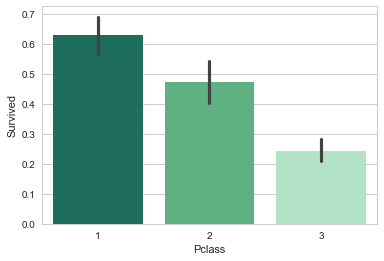

In [318]:
sns.barplot(data=train,x='Pclass',y='Survived',palette= {1: "#117A65", 2: "#52BE80",3: "#ABEBC6"})

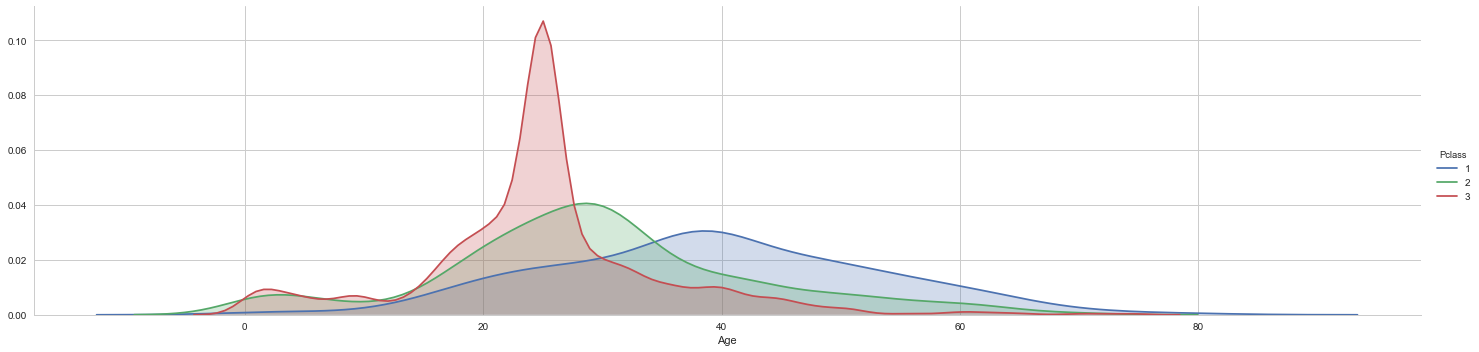

In [319]:
f = sns.FacetGrid(combined,hue='Pclass',size=5,aspect=4)
f.map(sns.kdeplot,'Age',shade= True)
f.add_legend()

This above graph is interesting but expected. 

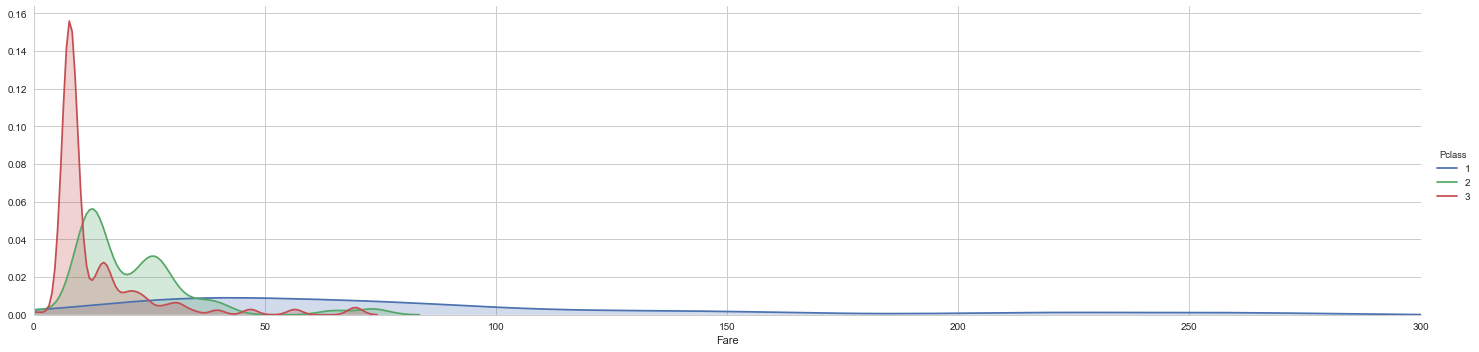

In [320]:
f = sns.FacetGrid(combined,hue='Pclass',size=5,aspect=4)
plt.xlim(0, 300)
f.map(sns.kdeplot,'Fare',shade= True)
f.add_legend()

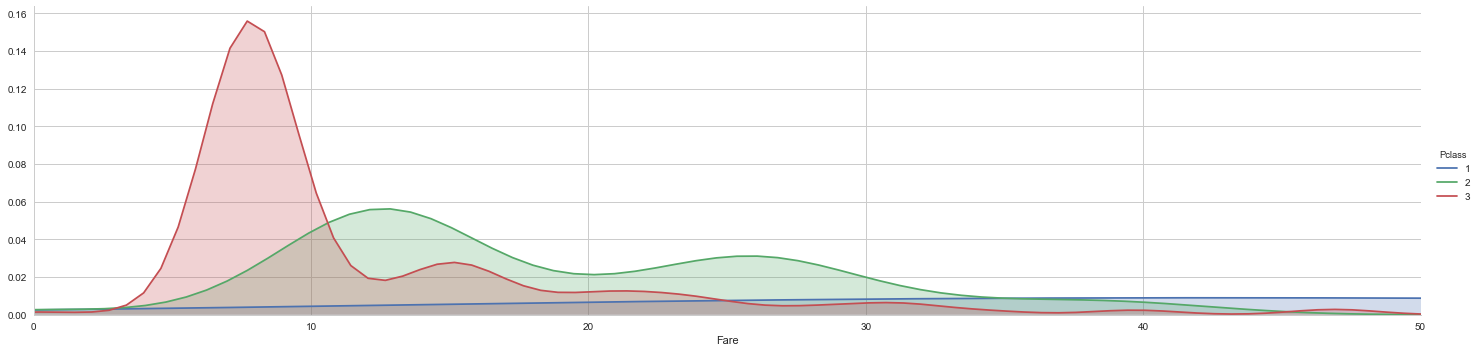

In [321]:
f = sns.FacetGrid(combined,hue='Pclass',size=5,aspect=4)
plt.xlim(0, 50)
f.map(sns.kdeplot,'Fare',shade= True)
f.add_legend()

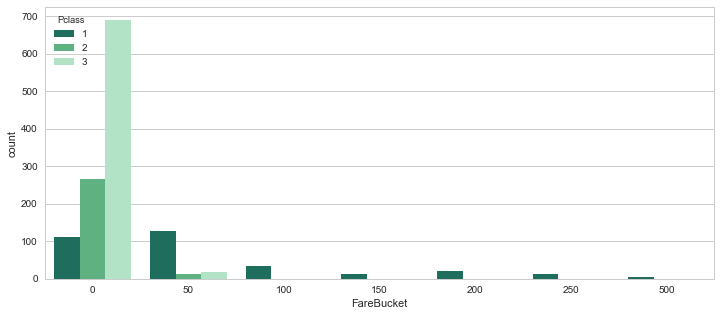

In [322]:
plt.figure(figsize=(12,5))
combined['FareBucket'] = (combined['Fare']/50).astype(int)*50
sns.countplot(data=combined,x='FareBucket',hue='Pclass',palette= {1: "#117A65", 2: "#52BE80",3: "#ABEBC6"})

In [323]:
combined[combined['Pclass']==1].sort_values('Fare').head()

,Age,Embarked,FamilySize,Fare,IsAlone,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FareBucket
822,38.0,S,0,0.0,1,"Reuchlin, Jonkheer. John George",0,823,1,male,0,0.0,19972,0
815,39.0,S,0,0.0,1,"Fry, Mr. Richard",0,816,1,male,0,0.0,112058,0
263,40.0,S,0,0.0,1,"Harrison, Mr. William",0,264,1,male,0,0.0,112059,0
266,39.0,S,0,0.0,1,"Chisholm, Mr. Roderick Robert Crispin",0,1158,1,male,0,NaN,112051,0
633,39.0,S,0,0.0,1,"Parr, Mr. William Henry Marsh",0,634,1,male,0,0.0,112052,0


I see that a few first class passengers did not pay for their cross atlantic sail. This is interesting. I looked it up and found that many passengers were given complimentary tickets. So let's find the lowest revenue first class ticket.

In [324]:
combined[(combined['Pclass']==1)&(combined['Fare']>0)].sort_values('Fare').head()

,Age,Embarked,FamilySize,Fare,IsAlone,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FareBucket
872,33.0,S,0,5.0000,1,"Carlsson, Mr. Frans Olof",0,873,1,male,0,0.0,695,0
662,47.0,S,0,25.5875,1,"Colley, Mr. Edward Pomeroy",0,663,1,male,0,0.0,5727,0
77,55.0,S,2,25.7000,0,"Cornell, Mrs. Robert Clifford (Malvina Helen L...",0,969,1,female,2,NaN,11770,0
205,39.0,C,0,25.7417,1,"Omont, Mr. Alfred Fernand",0,1097,1,male,0,NaN,F.C. 12998,0
168,39.0,S,0,25.9250,1,"Baumann, Mr. John D",0,169,1,male,0,0.0,PC 17318,0


Frans Olof paid just 5 pounds for his first class ticket. The encyclopedia-titanica article about him says that his company bought his ticket. I wish I knew his travel agent. Many first class passengers paid around 25 pounds which is considerably cheaper than the most expensive 3rd class ticket!

I am curious about the most expensive 3rd class ticket. Let's have a look.

In [325]:
combined[combined['Pclass']==3].sort_values('Fare',ascending=False).head(5)

,Age,Embarked,FamilySize,Fare,IsAlone,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FareBucket
159,25.0,S,10,69.55,0,"Sage, Master. Thomas Henry",2,160,3,male,8,0.0,CA. 2343,50
201,25.0,S,10,69.55,0,"Sage, Mr. Frederick",2,202,3,male,8,0.0,CA. 2343,50
846,25.0,S,10,69.55,0,"Sage, Mr. Douglas Bullen",2,847,3,male,8,0.0,CA. 2343,50
792,25.0,S,10,69.55,0,"Sage, Miss. Stella Anna",2,793,3,female,8,0.0,CA. 2343,50
188,25.0,S,10,69.55,0,"Sage, Miss. Ada",2,1080,3,female,8,NaN,CA. 2343,50


The highest 3rd class fares are associated with Ticket No CA. 2343. 11 passengers traveled on this ticket and 7 of them died. We do not know the fate of 4 who are the test set. This is unfortunate but reveals a very impotant charateristic about our data. I had ignored the 'Ticket' column till now but I should not ignore it. There is a good chance that they are from the same family. I hope someone from the Sage family survived.

In [326]:
combined[combined['Ticket']=='CA. 2343']

,Age,Embarked,FamilySize,Fare,IsAlone,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FareBucket
159,25.0,S,10,69.55,0,"Sage, Master. Thomas Henry",2,160,3,male,8,0.0,CA. 2343,50
180,25.0,S,10,69.55,0,"Sage, Miss. Constance Gladys",2,181,3,female,8,0.0,CA. 2343,50
201,25.0,S,10,69.55,0,"Sage, Mr. Frederick",2,202,3,male,8,0.0,CA. 2343,50
324,25.0,S,10,69.55,0,"Sage, Mr. George John Jr",2,325,3,male,8,0.0,CA. 2343,50
792,25.0,S,10,69.55,0,"Sage, Miss. Stella Anna",2,793,3,female,8,0.0,CA. 2343,50
846,25.0,S,10,69.55,0,"Sage, Mr. Douglas Bullen",2,847,3,male,8,0.0,CA. 2343,50
863,25.0,S,10,69.55,0,"Sage, Miss. Dorothy Edith ""Dolly""",2,864,3,female,8,0.0,CA. 2343,50
188,25.0,S,10,69.55,0,"Sage, Miss. Ada",2,1080,3,female,8,NaN,CA. 2343,50
342,25.0,S,10,69.55,0,"Sage, Mr. John George",9,1234,3,male,1,NaN,CA. 2343,50
360,14.5,S,10,69.55,0,"Sage, Master. William Henry",2,1252,3,male,8,NaN,CA. 2343,50


In [329]:
tst_sageFamily = test[test['Ticket']=='CA. 2343']
tst_sageFamily

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
188,1080,3,"Sage, Miss. Ada",female,25.0,8,2,CA. 2343,69.55,S,10,0
342,1234,3,"Sage, Mr. John George",male,25.0,1,9,CA. 2343,69.55,S,10,0
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,S,10,0
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,25.0,1,9,CA. 2343,69.55,S,10,0


I did some researching online for more information about their expensive 3rd class fare but I was not able to find anything concrete. There is a mention of the family changing plans (to sail aboard the Titanic instead of Philadelphia) due to the coal strike. Maybe they ended up buying these expensive tickets due to the late change of plans.

## Ticket Number

There are 40 groups with more than 2 passengers in the trainset. I will create a column called TicSurvProb that will contain the probability of survival of passengers who have these ticket numbers.

In [219]:
ticCount = train.groupby('Ticket')['Sex'].count()
ticSurN = train.groupby('Ticket')['Survived'].sum()
ticCount = pd.DataFrame(ticCount)
ticSurN = pd.DataFrame(ticSurN)
ticSur = ticCount.join(ticSurN)
ticSur['TicSurvProb'] = ticSur['Survived']*(100) /(ticSur['Sex'])
#ticSur['TicSurvProb'] = ticSur['Survived']*(100) 

ticSur.rename(index=str, columns={"Sex": "PassengerCount", "Survived": "PassengersSurvived"},inplace=True)
ticSur.reset_index(level=0, inplace=True)
len(ticSur)

681

In [220]:
ticSur.head()

,Ticket,PassengerCount,PassengersSurvived,TicSurvProb
0,110152,3,3,100.000000
1,110413,3,2,66.666667
2,110465,2,0,0.000000
3,110564,1,1,100.000000
4,110813,1,1,100.000000


In [221]:
ticSur = ticSur[ticSur['PassengerCount'] > 2]
len(ticSur)

40

In [222]:
train = pd.merge(train, ticSur, on=['Ticket', 'Ticket'],how='left')
train['TicSurvProb'] = train['TicSurvProb'].replace(np.NaN, 40)

In [223]:
len(train)

891

In [224]:
test = pd.merge(test, ticSur, on=['Ticket', 'Ticket'],how='left')
#s_valid['TicSurvProb'] = s_valid['TicSurvProb'].replace(np.NaN, 38.38)
print(test.isnull().sum()) 

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Embarked                0
FamilySize              0
IsAlone                 0
PassengerCount        391
PassengersSurvived    391
TicSurvProb           391
dtype: int64


In [225]:
test['TicSurvProb'] = test['TicSurvProb'].replace(np.NaN, 40)
len(test)

418

In [226]:
`1
test.drop(['PassengerCount','PassengersSurvived','Ticket'],axis=1,inplace=True)

In [227]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,TicSurvProb
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1,0,40.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,0,40.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,1,40.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,0,40.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,1,40.0


In [228]:
#train['TicSurvProb'].mean()

In [229]:
#38.38383838383838

## End Ticket Number

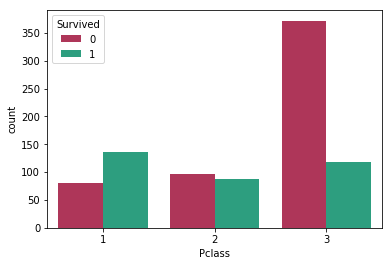

In [230]:
sns.countplot(data=train,x='Pclass',hue='Survived',palette= {1: "#1ab188", 0: "#c22250"})

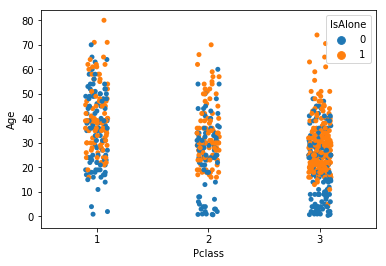

In [231]:
sns.stripplot(x='Pclass',y='Age',data=train,hue='IsAlone',jitter=True)

## Categorical Columns

In [232]:
train = pd.get_dummies(train, columns=['Embarked'])
test = pd.get_dummies(test, columns=['Embarked'])  


In [233]:
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

## Binning

Here, I split the Fare and Age columns to bins based on value. I can also create quantile bins using the pd.qcut function but I found better results based on value.

In [234]:
#from sklearn.preprocessing import LabelEncoder
#combined['FareBin'] = pd.qcut(combined['Fare'], 4)
#label = LabelEncoder()
#combined['FareBucket'] = label.fit_transform(combined['FareBin'])
#train['FareBucket'] = combined['FareBucket'][:891]
#test['FareBucket'] = combined['FareBucket'][891:]


In [235]:
train['FareBucket'] = (train['Fare']/50).astype(int)
test['FareBucket'] = (test['Fare']/50).astype(int)

In [236]:
#combined['AgeBin'] = pd.qcut(combined['Age'], 4)
#label = LabelEncoder()
#combined['AgeBand'] = label.fit_transform(combined['AgeBin'])
#train['AgeBand'] = combined['AgeBand'][:891]
#test['AgeBand'] = combined['AgeBand'][891:]

In [237]:
train['AgeBand'] = (train['Age']/5).astype(int)
test['AgeBand'] = (test['Age']/5).astype(int)

In [238]:
train.drop(['Age','Fare','PassengerId','Name','SibSp','Parch'], axis =1, inplace=True)
test.drop(['Age','Fare','Name','SibSp','Parch'], axis = 1, inplace=True)

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


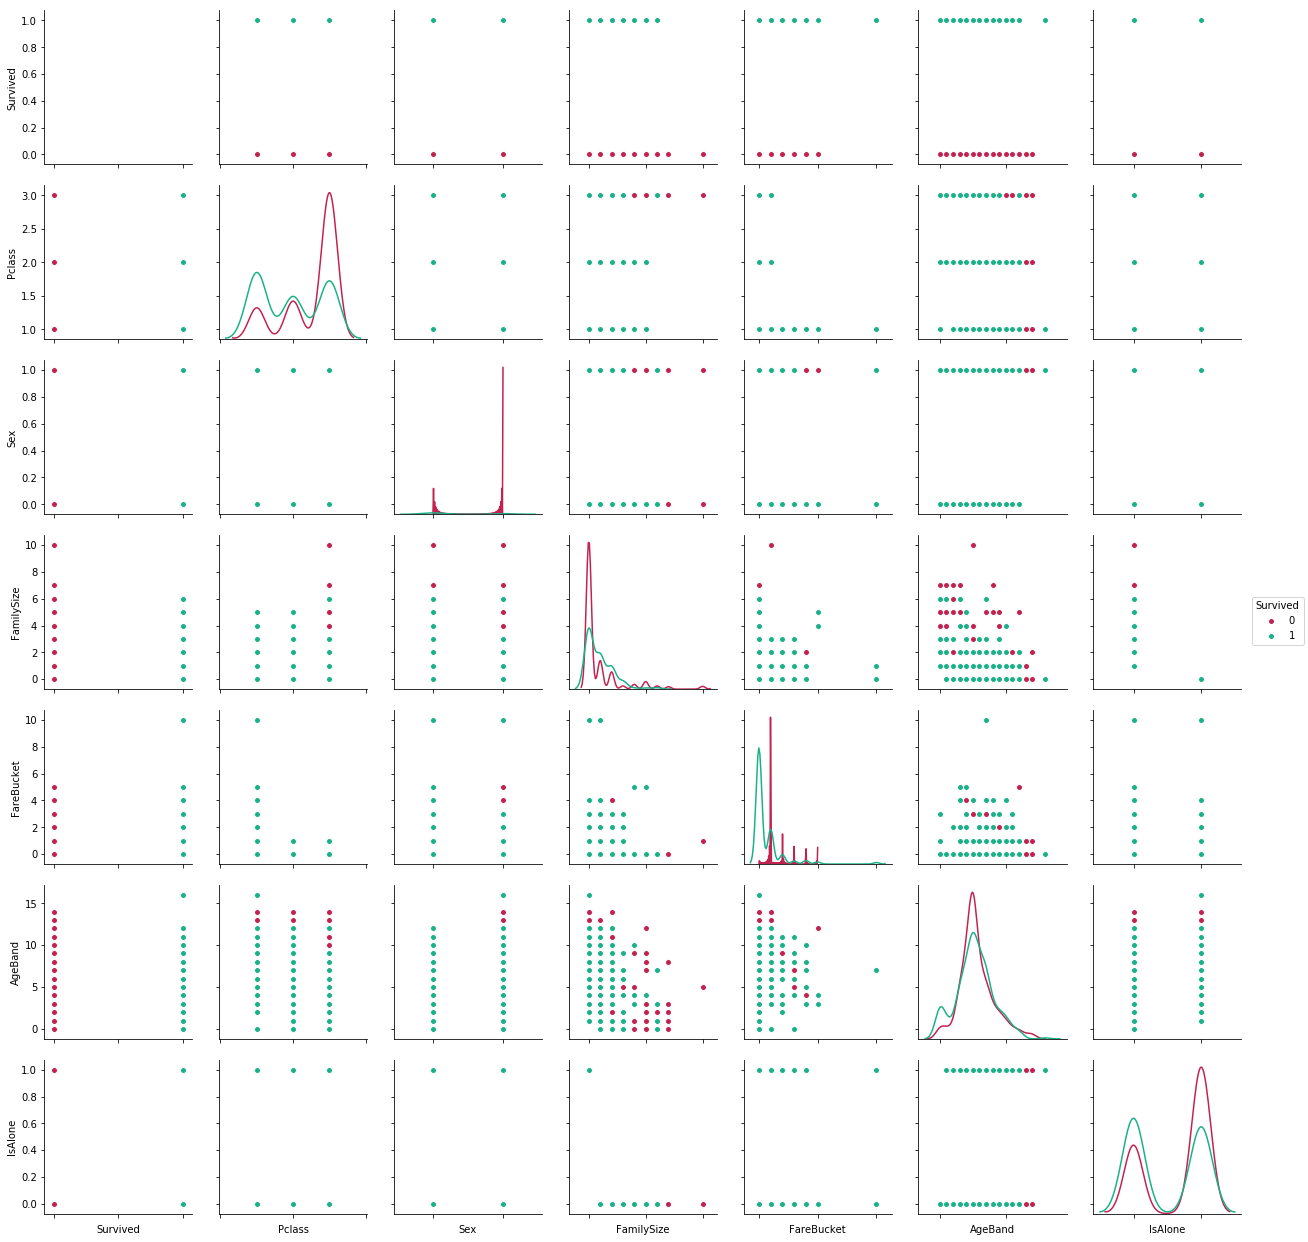

In [239]:
p = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'FamilySize', 'FareBucket','AgeBand', 'IsAlone']],hue='Survived', diag_kind = 'kde',palette= {1: "#1ab188", 0: "#c22250"} )
p.set(xticklabels=[])

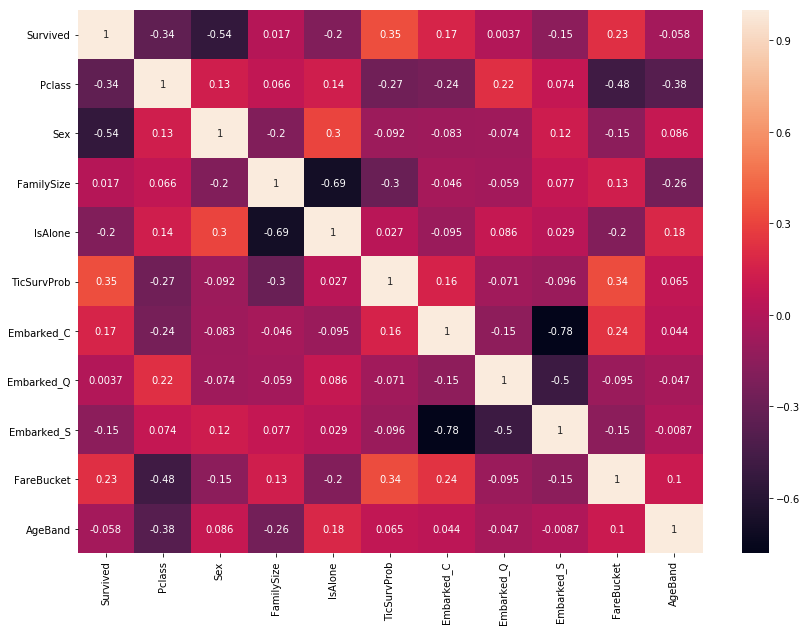

In [240]:
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(),annot=True)

The column 'Sex' has the highest correlation with Survived followed by 'TicSurvProb'.

In [241]:
pd.DataFrame(train.corr()['Survived']).abs().sort_values('Survived',ascending=False)

,Survived
Survived,1.000000
Sex,0.543351
TicSurvProb,0.345087
Pclass,0.338481
FareBucket,0.225942
IsAlone,0.203367
Embarked_C,0.168240
Embarked_S,0.149683
AgeBand,0.057515
FamilySize,0.016639


Insert x and y

In [242]:
from sklearn.model_selection import train_test_split
X = train.drop(['Survived'],axis=1)
y = train['Survived']


## Grid Search

In [243]:
from sklearn.grid_search import GridSearchCV

In [244]:
#XGB
#param_grid = {  
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5]
#        'n_estimators' : [80,90,100,150,200,500,800,1000,2000]
#        }
#grid = GridSearchCV(xgb.XGBClassifier(n_estimators=100,colsample_bytree= 0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0),param_grid,verbose=3)
#grid.fit(X,y)

In [245]:
#print(grid.best_params_)
#print(grid.best_score_)

In [246]:
#SVC
#param_grid = {  
#        'C': [0.001, 0.01, 0.1, 1, 10],
#        'gamma': [0.001, 0.01, 0.1, 1]
#        }
#grid = GridSearchCV(SVC(),param_grid,verbose=3)
#grid.fit(X,y)

In [247]:
#print(grid.best_params_)
#print(grid.best_score_)

In [248]:
#KNN

In [249]:
#k_range = list(range(1, 40))
#param_grid = dict(n_neighbors=k_range)
#grid = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=3)
#grid.fit(X,y)


In [250]:
#print(grid.best_params_)
#print(grid.best_score_)

## Cross Validation

I will use the entire train data to perform Cross Validation. I may get better results with KNN and SVC if I scale the data but I have skipped that step.

In [251]:
from sklearn.model_selection import KFold 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
num_of_estimators = 500
rfClass = RandomForestClassifier(n_estimators=200,max_depth=3,
                                 min_samples_leaf= 1,max_features=5,min_samples_split=3,criterion='entropy')
logClass = LogisticRegression(penalty='l1',C=21.544346900318832)
svcClass = SVC(gamma=0.001,C=10)
knnClass = KNeighborsClassifier(n_neighbors=9)
xgbClass = xgb.XGBClassifier(n_estimators=100,colsample_bytree= 0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0)
nbClass = MultinomialNB()
adaClass = AdaBoostClassifier(n_estimators=20,learning_rate=0.2)
extraTreesClass = ExtraTreesClassifier(n_estimators=50,bootstrap=False,criterion='entropy',max_features=3,min_samples_leaf=3,
                                        min_samples_split=10,max_depth=None)
gradientBClass = GradientBoostingClassifier(n_estimators=20,max_depth=3,max_features= 5,min_samples_leaf=3,min_samples_split=2)
res_alg = ['Random Forest','Logistic Regression','SVC','KNN','XG Boost','Naive Bayes','ADA Boost','Extra Trees','Gradient Boost']
res_acc = []
res_acc.append(cross_val_score(rfClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(logClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(svcClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(knnClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(xgbClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(nbClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(adaClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(extraTreesClass,X,y,scoring='accuracy',cv=10).mean()*100)
res_acc.append(cross_val_score(gradientBClass,X,y,scoring='accuracy',cv=10).mean()*100)

In [252]:
cv_results = pd.DataFrame({'Algorithm':res_alg,
                  'Accuracy':res_acc})

In [253]:
cv_results.sort_values('Accuracy',ascending=False)

,Accuracy,Algorithm
4,83.052009,XG Boost
0,82.828538,Random Forest
6,82.828538,ADA Boost
8,82.605124,Gradient Boost
2,82.486437,SVC
7,81.929577,Extra Trees
1,81.704943,Logistic Regression
3,76.777182,KNN
5,76.231841,Naive Bayes


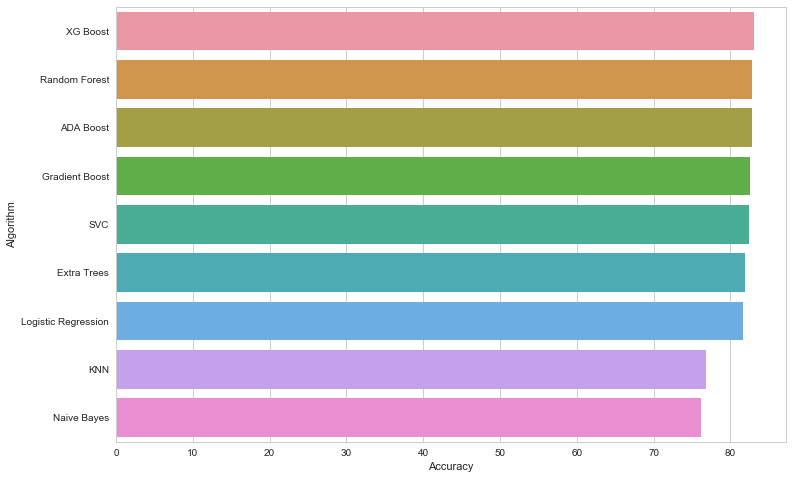

In [254]:
plt.figure(figsize=(12,8))
cv_results = cv_results.sort_values(['Accuracy'],ascending=False).reset_index(drop=True)
sns.set(style="whitegrid")
sns.barplot(data=cv_results,x='Accuracy',y='Algorithm')


## Stacking

In [255]:
#Build base models

In [256]:
len(X) #Length before splitting:891 Source - Coursera Advanced ML

891

I will divide the training data set into 3 subsets - s_train, s_valid and s_test. s_train will be used to train the base models. I will use these base models to make predictions on the s_valid dataset. I will then make a data frame of all the predictions and this will server as the training data to the meta model. s_test will be used to test the model.

Divide into train and a temporary test set

In [257]:
X_s_train, X_s_test2, y_s_train, y_s_test2 = train_test_split(X, y, test_size=0.5)
#s_train, s_temp_test = train_test_split(train, test_size=0.5)

Divide the temporary test set into validate and test

In [258]:
X_s_valid, X_s_test, y_s_valid, y_s_test = train_test_split(X_s_test2, y_s_test2, test_size=0.1)
#s_valid, s_test = train_test_split(s_temp_test,  test_size=0.1)

In [259]:
print(len(X_s_train)) #length of Train: 534  (60%)
print(len(X_s_valid)) #length of Validate: 178 (20%)
print(len(X_s_test)) #length of Test: 179 (20%)

445
401
45


Train the base models with s_train

In [260]:
rfClass.fit(X_s_train,y_s_train)
adaClass.fit(X_s_train,y_s_train)
extraTreesClass.fit(X_s_train,y_s_train)
logClass.fit(X_s_train,y_s_train)
xgbClass.fit(X_s_train,y_s_train)
svcClass.fit(X_s_train,y_s_train)
knnClass.fit(X_s_train,y_s_train)
gradientBClass.fit(X_s_train,y_s_train)

#predict these models on validate data
vld_rfPred = rfClass.predict(X_s_valid)
vld_adaPred = adaClass.predict(X_s_valid)
vld_extPred = extraTreesClass.predict(X_s_valid)
vld_logPred = logClass.predict(X_s_valid)
vld_xgbPred = xgbClass.predict(X_s_valid)
vld_svcPred = svcClass.predict(X_s_valid)
vld_knnPred = knnClass.predict(X_s_valid)
vld_gbPred =  gradientBClass.predict(X_s_valid)

In [261]:
base_predictions_train = pd.DataFrame( {
    'RandomForest': vld_rfPred,
    'AdaptiveBoost': vld_adaPred,
    'ExtraTrees': vld_extPred,
    'Log': vld_logPred,
    'XGB': vld_xgbPred,  
    'SVC': vld_svcPred,
    'KNN': vld_knnPred,
    'GB' : vld_gbPred,
    'Y': y_s_valid,
    })
base_predictions_train.head()

,AdaptiveBoost,ExtraTrees,GB,KNN,Log,RandomForest,SVC,XGB,Y
850,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0
684,0,0,0,0,0,0,0,0,0
807,1,1,1,0,1,1,0,1,0
135,0,0,0,0,0,0,0,0,0


In [262]:
#Analyze Stack Result Begin

In [263]:
def generateMatchScore(row):
    score =0
    if(row['AdaptiveBoost'] == row['Y']):
        score = score + 1
    if(row['ExtraTrees'] == row['Y']):
        score = score + 1
    if(row['KNN'] == row['Y']):
        score = score + 1
    if(row['Log'] == row['Y']):
        score = score + 1
    if(row['RandomForest'] == row['Y']):
        score = score + 1
    if(row['SVC'] == row['Y']):
        score = score + 1
    if(row['XGB'] == row['Y']):
        score = score + 1
    return score
        


In [264]:
base_predictions_train['Score'] = base_predictions_train.apply(generateMatchScore, axis=1)

In [265]:
base_predictions_train[base_predictions_train['Score'] ==1]

,AdaptiveBoost,ExtraTrees,GB,KNN,Log,RandomForest,SVC,XGB,Y,Score
660,0,0,0,1,0,0,0,0,1,1
888,1,1,1,0,1,1,1,1,0,1
724,0,0,0,1,0,0,0,0,1,1
248,0,0,0,1,0,0,0,0,1,1
729,1,1,1,0,1,1,1,1,0,1
617,1,1,1,0,1,1,1,1,0,1
254,1,1,1,0,1,1,1,1,0,1
621,0,0,0,1,0,0,0,0,1,1
690,0,0,0,1,0,0,0,0,1,1


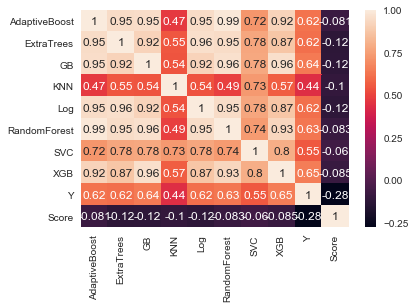

In [266]:
sns.heatmap(base_predictions_train.corr(),annot=True)

In [267]:
#Concatenate all predictions on Validate
stacked_valid_predictions = np.column_stack((vld_rfPred, vld_adaPred, vld_extPred,vld_logPred,vld_xgbPred,
                                             vld_svcPred,vld_knnPred,vld_gbPred))

Create meta model

In [268]:
#meta_model = RandomForestClassifier(n_estimators=20,bootstrap=True,criterion='gini',max_depth= None, 
#                                          max_features=1, min_samples_leaf=1, min_samples_split=10)
meta_model = xgb.XGBClassifier(n_estimators=90,colsample_bytree=0.8, gamma=5, max_depth=3,
                                      min_child_weight=10, subsample=0.6)
#meta_model = KNeighborsClassifier()
#from sklearn.tree import DecisionTreeClassifier
#meta_model = DecisionTreeClassifier()
#meta_model = SVC(C=10,gamma=0.01)

Fit meta model on Validate subset

In [269]:
meta_model.fit(stacked_valid_predictions,y_s_valid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [270]:
feature_importances = pd.DataFrame(meta_model.feature_importances_,index = ['vld_rfPred', 'vld_adaPred', 'vld_extPred','vld_logPred','vld_xgbPred',
                                             'vld_svcPred','vld_knnPred','vld_gbPred'],columns=['importance']).sort_values('importance',   ascending=False)
feature_importances

,importance
vld_xgbPred,0.40
vld_knnPred,0.16
vld_gbPred,0.16
vld_rfPred,0.12
vld_extPred,0.12
vld_logPred,0.04
vld_adaPred,0.00
vld_svcPred,0.00


Use Base Models to predict on s_test set

In [271]:
tst_rfPred = rfClass.predict(X_s_test)
tst_adaPred = adaClass.predict(X_s_test)
tst_extPred = extraTreesClass.predict(X_s_test)
tst_logPred = logClass.predict(X_s_test)
tst_xgbPred = xgbClass.predict(X_s_test)
tst_svcPred = svcClass.predict(X_s_test)
tst_knnPred = knnClass.predict(X_s_test)
tst_gbPred = gradientBClass.predict(X_s_test)

#Concatenate base model predictions on Test
stacked_test_predictions = np.column_stack((tst_rfPred, tst_adaPred, tst_extPred,tst_logPred,tst_xgbPred,
                                           tst_svcPred,tst_knnPred,tst_gbPred))


Use the predictions from the above step as input to the meta model

In [272]:
#Predict Test predictions using meta model 
s_test_pred = meta_model.predict(stacked_test_predictions)

In [273]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_s_test,s_test_pred))

             precision    recall  f1-score   support

          0       0.92      0.79      0.85        29
          1       0.70      0.88      0.78        16

avg / total       0.84      0.82      0.83        45



 Predictions on Test Data for submission

In [274]:
X_test = test.drop(['PassengerId'],axis=1)

In [330]:
#Use the base models to make predictions on test set
t_rfPred = rfClass.predict(X_test)
t_adaPred = adaClass.predict(X_test)
t_extPred = extraTreesClass.predict(X_test)
t_logPred = logClass.predict(X_test)
t_xgbPred = xgbClass.predict(X_test)
t_svcPred = svcClass.predict(X_test)
t_knnPred = knnClass.predict(X_test)
t_gbPred = gradientBClass.predict(X_test)

#Concatenate base model predictions on Test
stacked_t_predictions = np.column_stack((t_rfPred, t_adaPred, t_extPred,t_logPred,t_xgbPred,t_svcPred,t_knnPred,t_gbPred))
#Use the meta model to make predictions on test set
final_pred = meta_model.predict(stacked_t_predictions)

Before we submit, lets check if the 4 remaining passengers of the Sage family survived

In [331]:
tst_sageFamily

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
188,1080,3,"Sage, Miss. Ada",female,25.0,8,2,CA. 2343,69.55,S,10,0
342,1234,3,"Sage, Mr. John George",male,25.0,1,9,CA. 2343,69.55,S,10,0
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,S,10,0
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,25.0,1,9,CA. 2343,69.55,S,10,0


In [332]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": final_pred
    })


In [333]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [337]:
tst_sageFamily.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
188,1080,3,"Sage, Miss. Ada",female,25.0,8,2,CA. 2343,69.55,S,10,0
342,1234,3,"Sage, Mr. John George",male,25.0,1,9,CA. 2343,69.55,S,10,0
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,S,10,0
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,25.0,1,9,CA. 2343,69.55,S,10,0


In [338]:
#submission['PassengerId'] in tst_sageFamily['PassengerId']
tst_sageFamily.merge(submission,how='left',on='PassengerId')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone,Survived
0,1080,3,"Sage, Miss. Ada",female,25.0,8,2,CA. 2343,69.55,S,10,0,0
1,1234,3,"Sage, Mr. John George",male,25.0,1,9,CA. 2343,69.55,S,10,0,0
2,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,S,10,0,0
3,1257,3,"Sage, Mrs. John (Annie Bullen)",female,25.0,1,9,CA. 2343,69.55,S,10,0,0


In [ ]:
submission.to_csv('titanic_output.csv', index=False)